In [ ]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.model_selection import KFold
from sklearn.preprocessing import StandardScaler
from sklearn.linear_model import LinearRegression, LogisticRegression
from sklearn.ensemble import RandomForestRegressor, RandomForestClassifier
from sklearn.metrics import mean_squared_error, r2_score, log_loss, accuracy_score
import statsmodels.api as sm
from scipy.stats import ttest_rel, wilcoxon
import warnings
warnings.filterwarnings('ignore')
sns.set(style='whitegrid')

df = pd.read_csv('forestfires.csv')

X.shape: (517, 12) y.shape: (517,)


In [13]:
from sklearn.preprocessing import LabelEncoder

df_le = df.copy()
cat_features = ['month', 'day']
le = LabelEncoder()
for feature in cat_features:
    df_le[feature] = le.fit_transform(df_le[feature])
df = df_le.copy()
df.head()

,X,Y,month,day,FFMC,DMC,DC,ISI,temp,RH,wind,rain,area
0,7,5,7,0,86.2,26.2,94.3,5.1,8.2,51,6.7,0.0,0.0
1,7,4,10,5,90.6,35.4,669.1,6.7,18.0,33,0.9,0.0,0.0
2,7,4,10,2,90.6,43.7,686.9,6.7,14.6,33,1.3,0.0,0.0
3,8,6,7,0,91.7,33.3,77.5,9.0,8.3,97,4.0,0.2,0.0
4,8,6,7,3,89.3,51.3,102.2,9.6,11.4,99,1.8,0.0,0.0


In [15]:
X = df.drop(columns=['area'])
y = df['area']


print("X.shape:", X.shape, "y.shape:", y.shape)

X.shape: (517, 12) y.shape: (517,)


In [ ]:

# Блок 3: Настройка CV и кандидатов моделей
K = 5
kf = KFold(n_splits=K, shuffle=True, random_state=0)

# Унивариативный кандидат: лучший отдельный признак (по CV metric)
# Мультивариативные кандидаты: линейная и случайный лес
multi_models = {
    'LinearRegression': LinearRegression(),
}

# Блок 4: Функции для CV и метрик
def cv_metrics_regression(model, X, y, kf):
    metrics = []
    preds = []
    for train_idx, test_idx in kf.split(X):
        model.fit(X.iloc[train_idx], y.iloc[train_idx])
        yhat = pd.Series(model.predict(X.iloc[test_idx]), index=test_idx)
        rmse = np.sqrt(mean_squared_error(y.iloc[test_idx], yhat))
        r2 = r2_score(y.iloc[test_idx], yhat)
        metrics.append({'rmse': rmse, 'r2': r2})
        preds.append((test_idx, yhat))
    return pd.DataFrame(metrics), preds

# Блок 5: Найдём лучший одиночный признак
results_uni = []
for col in X.columns:
    X_col = X[[col]]
    model = LinearRegression()
    df_metrics, _ = cv_metrics_regression(model, X_col, y, kf)
    results_uni.append((col, df_metrics['rmse'].mean(), df_metrics['rmse'].std(), df_metrics))

results_uni.sort(key=lambda x: x[1])   # сортируем по mean RMSE (меньше лучше)

best_uni = results_uni[0]
print("Best univariate feature:", best_uni[0], "mean_rmse:", best_uni[1], "std_rmse:", best_uni[2])

Best univariate feature: day mean_rmse: 53.362024329308426 std_rmse: 38.85131252071099


LinearRegression mean metrics:
 {'rmse': 54.821621726369315, 'r2': -0.2501079968380684}
RandomForest mean metrics:
 {'rmse': 57.460410062952874, 'r2': -0.5276631720381509}
BIC OLS full: {'bic': 5829.172571700619, 'llf': -2873.974007166005, 'k': 13}
BIC OLS uni : {'bic': 5773.201960303399, 'llf': -2880.352937277191, 'k': 2}
BF (uni over full) ≈ 1.43e+12
Интерпретация: Очень сильная поддержка модели 1 (Uni)
Compare UNI(day) vs LinearRegression: t_p=0.2928, wilcoxon_p=0.625
Compare UNI(day) vs RandomForest: t_p=0.1311, wilcoxon_p=0.125


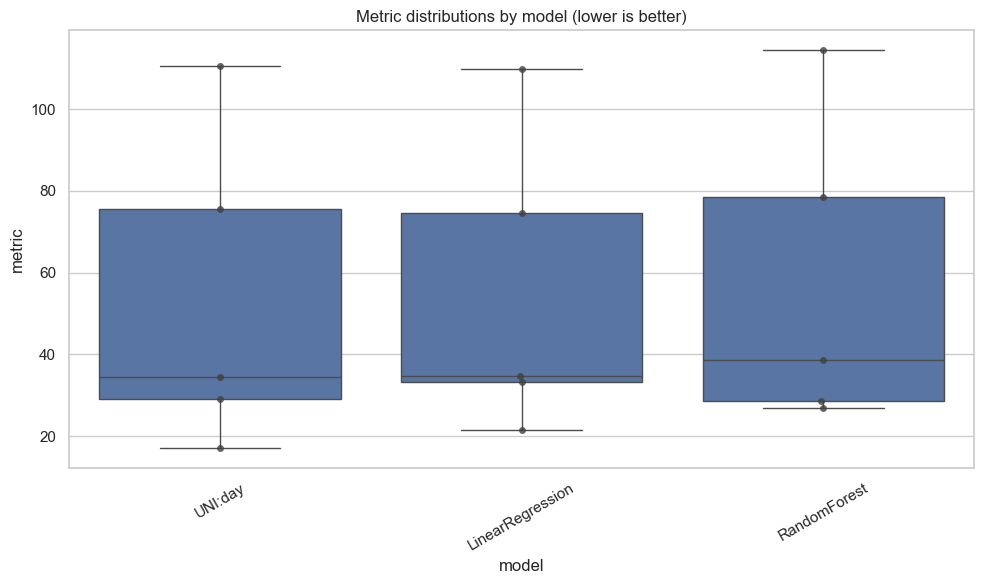

,model,mean_metric,std_metric,bic
0,UNI:day,53.362024,38.851313,5773.201960
1,LinearRegression,54.821622,36.708926,5829.172572
2,RandomForest,57.460410,38.091572,5829.172572


INTRODUCTION

Data shape: X=(517, 12), y=(517,)


PERFORMANCE SUMMARY

           model  mean_metric  std_metric         bic
         UNI:day    53.362024   38.851313 5773.201960
LinearRegression    54.821622   36.708926 5829.172572
    RandomForest    57.460410   38.091572 5829.172572


BIC values:

OLS_full: bic=5829.172571700619, llf=-2873.974007166005

OLS_uni: bic=5773.201960303399, llf=-2880.352937277191


Bayes Factor (uni over full) ≈ 1.43e+12


STATISTICAL TESTS


STATISTICAL TESTS

Hypotheses for each comparison (two-sided):

  H0: mean(metric_UNI) == mean(metric_MULTI)

  H1: mean(metric_UNI) != mean(metric_MULTI)


Test results (alpha=0.05):

UNI:day vs LinearRegression: metric=rmse

  t-test: stat=-1.2101909190194706, p=0.29282780086572796, decision: fail to reject H0

  wilcoxon: stat=5.0, p=0.625, decision: fail to reject H0

UNI:day vs RandomForest: metric=rmse

  t-test: stat=-1.894275649361606, p=0.13110188796444308, decision: fail to reject H0

  wilcoxon: stat=1.0, 

In [ ]:
# Блок 6: CV для мультивариативных моделей
multi_metrics = {}
for name, model in multi_models.items():
    metrics_df, preds = cv_metrics_regression(model, X, y, kf)
    multi_metrics[name] = {'metrics': metrics_df, 'preds': preds}
    print(name, "mean metrics:\n", metrics_df.mean().to_dict())

# Блок 7: Рассчитаем BIC / log-likelihood для параметрических моделей (statsmodels)
# Для регрессии: линейная модель через OLS (на всех данных)
bic_dict = {}

X_sm = sm.add_constant(X)  # включает константу
ols = sm.OLS(y, X_sm).fit()
bic_dict['OLS_full'] = {'bic': float(ols.bic), 'llf': float(ols.llf), 'k': int(ols.df_model + 1)}
# Для лучшего унивариативного признака:
col = best_uni[0]
X_sm_uni = sm.add_constant(X[[col]])
ols_uni = sm.OLS(y, X_sm_uni).fit()
bic_dict['OLS_uni'] = {'bic': float(ols_uni.bic), 'llf': float(ols_uni.llf), 'k': int(ols_uni.df_model + 1)}
print("BIC OLS full:", bic_dict['OLS_full'])
print("BIC OLS uni :", bic_dict['OLS_uni'])

# Блок 8: Bayes Factor (приближённо через разницу BIC)
# BF_{1 over 2} ≈ exp((BIC2 - BIC1)/2)
def bayes_factor_from_bic(bic1, bic2):
    return np.exp((bic2 - bic1) / 2.0)

# Считаем BF между OLS_full и OLS_uni (если есть)
if ('OLS_full' in bic_dict) and ('OLS_uni' in bic_dict):
    bic1 = bic_dict['OLS_uni']['bic']
    bic2 = bic_dict['OLS_full']['bic']
    bf = bayes_factor_from_bic(bic1, bic2)  # BF uni over full
    print(f"BF (uni over full) ≈ {bf:.3g}")
    # интерпретация по Джеффриса
    def interpret_bf(bf):
        if bf < 1/100:
            return "Очень сильная поддержка модели 2 (Full)"
        if bf < 1/10:
            return "Сильная поддержка модели 2 (Full)"
        if bf < 1/3:
            return "Умеренная поддержка модели 2 (Full)"
        if bf < 1:
            return "Слабая поддержка модели 2 (Full)"
        if bf == 1:
            return "Нет различий"
        if bf <= 3:
            return "Слабая поддержка модели 1 (Uni)"
        if bf <= 10:
            return "Умеренная поддержка модели 1 (Uni)"
        if bf <= 30:
            return "Сильная поддержка модели 1 (Uni)"
        return "Очень сильная поддержка модели 1 (Uni)"
    print("Интерпретация:", interpret_bf(bf))

# Блок 9: Статистические парные тесты по CV метрикам
# Сравним лучшую унивариативную модель и каждую мульти-модель по распределениям метрик
# Соберём векторы метрик (по fold) для сравнения
# лучший uni: получить его CV метрики (we stored df in best_uni[3])
uni_metrics_df = best_uni[3]  # DataFrame с K метриками
for name, info in multi_metrics.items():
    multi_df = info['metrics']
    # используем RMSE сравнение: uni rmse vs multi rmse
    try:
        uni_vec = uni_metrics_df['rmse'].values
        multi_vec = multi_df['rmse'].values
        # парный t-test
        t_stat, p_val = ttest_rel(uni_vec, multi_vec)
        # wilcoxon (если не нормальное)
        try:
            w_stat, w_p = wilcoxon(uni_vec, multi_vec)
        except Exception:
            w_stat, w_p = (np.nan, np.nan)
        print(f"Compare UNI({best_uni[0]}) vs {name}: t_p={p_val:.4f}, wilcoxon_p={w_p}")
    except Exception as e:
        print("Compare failed:", e)

# %% [markdown]
# Блок 10: Визуализации распределений метрик (boxplot / violin)
plt.figure(figsize=(10,6))
plot_df = []

for i,val in enumerate(uni_metrics_df['rmse']):
    plot_df.append({'model': f'UNI:{best_uni[0]}', 'fold': i, 'metric': val})
for name, info in multi_metrics.items():
    for i,val in enumerate(info['metrics']['rmse']):
        plot_df.append({'model': name, 'fold': i, 'metric': val})


plot_df = pd.DataFrame(plot_df)
sns.boxplot(x='model', y='metric', data=plot_df)
sns.swarmplot(x='model', y='metric', data=plot_df, color='0.25', alpha=0.8)
plt.title('Metric distributions by model (lower is better)')
plt.xticks(rotation=30)
plt.tight_layout()
plt.show()

# %% [markdown]
# Блок 11: Таблица сравнения (mean ± std), BIC и BF где применимо
rows = []

rows.append({
    'model': f'UNI:{best_uni[0]}',
    'mean_metric': uni_metrics_df['rmse'].mean(),
    'std_metric': uni_metrics_df['rmse'].std(),
    'bic': bic_dict.get('OLS_uni', {}).get('bic', np.nan)
})

for name, info in multi_metrics.items():
    dfm = info['metrics']
    key = 'rmse'
    rows.append({
        'model': name,
        'mean_metric': dfm[key].mean(),
        'std_metric': dfm[key].std(),
        'bic': bic_dict.get('OLS_full', {}).get('bic', np.nan)
    })

comp_df = pd.DataFrame(rows).sort_values('mean_metric')
display(comp_df)

# Блок 12: Краткий автоматический отчёт (строки, которые можно сохранить в файл)
report = []
report.append("INTRODUCTION")
report.append(f"Data shape: X={X.shape}, y={y.shape}")
report.append("\nPERFORMANCE SUMMARY")
report.append(comp_df.to_string(index=False))
# BF summary
if len(bic_dict) >= 2:
    report.append("\nBIC values:")
    for k,v in bic_dict.items():
        report.append(f"{k}: bic={v['bic']}, llf={v['llf']}")
    if 'OLS_uni' in bic_dict and 'OLS_full' in bic_dict:
        bf_val = bayes_factor_from_bic(bic_dict['OLS_uni']['bic'], bic_dict['OLS_full']['bic'])
        report.append(f"\nBayes Factor (uni over full) ≈ {bf_val:.3g}")
report.append("\nSTATISTICAL TESTS")


# ==== Добавляем формулировку гипотез и вычисление тестов ====
# Гипотезы (двусторонние) для каждой пары UNI vs MULTI:
#   H0: Средняя метрика UNI == Средняя метрика MULTI
#   H1: Средняя метрика UNI != Средняя метрика MULTI
stat_tests_results = []
TASK = 'regression'
if TASK == 'regression':
    uni_vec = best_uni[3]['rmse'].values  # rmse по fold для uni
    metric_name = 'rmse'
else:
    uni_vec = best_uni[3]['logloss'].values
    metric_name = 'logloss'

for name, info in multi_metrics.items():
    multi_vec = info['metrics'][metric_name].values
    # парный t-test
    try:
        t_stat, t_p = ttest_rel(uni_vec, multi_vec)
    except Exception:
        t_stat, t_p = (np.nan, np.nan)
    # Wilcoxon signed-rank test (непараметрический)
    try:
        w_stat, w_p = wilcoxon(uni_vec, multi_vec)
    except Exception:
        w_stat, w_p = (np.nan, np.nan)

    # Решение при alpha=0.05
    alpha = 0.05
    t_decision = 'reject H0' if (not np.isnan(t_p) and t_p < alpha) else 'fail to reject H0'
    w_decision = 'reject H0' if (not np.isnan(w_p) and w_p < alpha) else 'fail to reject H0'

    stat_tests_results.append({
        'pair': f'UNI:{best_uni[0]} vs {name}',
        'metric': metric_name,
        't_stat': float(t_stat) if not np.isnan(t_stat) else None,
        't_p': float(t_p) if not np.isnan(t_p) else None,
        't_decision': t_decision,
        'w_stat': float(w_stat) if not np.isnan(w_stat) else None,
        'w_p': float(w_p) if not np.isnan(w_p) else None,
        'w_decision': w_decision
    })

# Включаем результаты тестов в отчет
report.append("\nSTATISTICAL TESTS")
report.append("Hypotheses for each comparison (two-sided):")
report.append("  H0: mean(metric_UNI) == mean(metric_MULTI)")
report.append("  H1: mean(metric_UNI) != mean(metric_MULTI)")
report.append("\nTest results (alpha=0.05):")
for r in stat_tests_results:
    report.append(f"{r['pair']}: metric={r['metric']}")
    report.append(f"  t-test: stat={r['t_stat']}, p={r['t_p']}, decision: {r['t_decision']}")
    report.append(f"  wilcoxon: stat={r['w_stat']}, p={r['w_p']}, decision: {r['w_decision']}")
report.append("See printed p-values above (t-test and Wilcoxon) for pairwise comparisons between UNI and each multi model.")
report.append("\nCONCLUSION")
report.append("Choose model balancing predictive performance, statistical significance (p-values), and Bayes Factor (BIC based).")

print("\n\n".join(report))